# Neural Network classifier

## install necessary libraries to train locally

In [1]:
# !pip install torch torchvision torchaudio

## Import necessari ibraries

In [2]:
#Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score, recall_score, f1_score)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings
warnings.filterwarnings('ignore')


## Read dataset and observation

In [3]:
# Mount Google Drive (persistent storage)
#drive.mount('/content/drive')
# Load dataset (replace with your path)
file_path = 'combined_dataset.csv'
data = pd.read_csv(file_path)


In [4]:

# Data Preprocessing
print("Original shape:", data.shape)


Original shape: (28789809, 13)


In [5]:
# Handle missing values
data = data.dropna()
print("After dropping NA:", data.shape)


After dropping NA: (28789809, 13)


In [6]:
labels = data['Label'].unique()
print("Classes:", labels)

Classes: [1 0]


In [7]:
data["Label"].value_counts()

Label
1    20007392
0     8782417
Name: count, dtype: int64

## Split to training and testing data

In [8]:

# Feature-Target Split
X = data.drop('Label', axis=1).values
y = data['Label'].values

# Train-Validation-Test Split (60-20-20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


## Scaling because nn needs scaling

In [9]:

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


## Choose hyperparaeters and Training

In [10]:
# Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.LongTensor(y_train)
X_val_t = torch.FloatTensor(X_val)
y_val_t = torch.LongTensor(y_val)
X_test_t = torch.FloatTensor(X_test)
y_test_t = torch.LongTensor(y_test)


In [11]:
# Create DataLoaders
batch_size = 1024
train_data = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_data = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_data, batch_size=batch_size)


In [12]:
# Neural Network Architecture
class BotNetDetector(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, len(labels))  # Output layer

        self.dropout = nn.Dropout(0.3)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [13]:
# Initialize model
input_size = X_train.shape[1]
model = BotNetDetector(input_size)


In [14]:
# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


In [15]:
# Early stopping parameters
patience = 5
best_val_loss = float('inf')
counter = 0


In [19]:
import torch

# Set the device to a GPU (cuda) if available, otherwise use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [20]:
# Training loop
epochs = 50
train_losses = []
val_losses = []
val_accuracies = []

print("\nStarting training...")

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save best model
        torch.save(model.state_dict(), 'new_botnet_nn_best.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Acc: {val_acc:.4f}")




Starting training...
Epoch 1/50 - Train Loss: 0.2803 - Val Loss: 0.3164 - Val Acc: 0.8480
Epoch 2/50 - Train Loss: 0.2723 - Val Loss: 0.2957 - Val Acc: 0.8479
Epoch 3/50 - Train Loss: 0.2689 - Val Loss: 0.2683 - Val Acc: 0.8538
Epoch 4/50 - Train Loss: 0.2672 - Val Loss: 0.2663 - Val Acc: 0.8491
Epoch 5/50 - Train Loss: 0.2667 - Val Loss: 0.2640 - Val Acc: 0.8488
Epoch 6/50 - Train Loss: 0.2576 - Val Loss: 0.3191 - Val Acc: 0.8488
Epoch 7/50 - Train Loss: 0.2459 - Val Loss: 0.2764 - Val Acc: 0.8489
Epoch 8/50 - Train Loss: 0.2218 - Val Loss: 0.5556 - Val Acc: 0.8486
Epoch 9/50 - Train Loss: 0.1998 - Val Loss: 0.4845 - Val Acc: 0.8484
Early stopping at epoch 10


## Load best model  to evaluate it

In [22]:
# Load best model
model.load_state_dict(torch.load('new_botnet_nn_best.pth'))
model.eval()


BotNetDetector(
  (fc1): Linear(in_features=12, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Evaluation

In [23]:
# Evaluation on test set
y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)[:, 1]  # Probability of positive class


In [24]:
# Metrics
print("\n=== Test Set Performance ===")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_true, y_pred):.4f}")



=== Test Set Performance ===
Accuracy: 0.8488
Precision: 0.8254
Recall: 0.9923
F1-Score: 0.9012


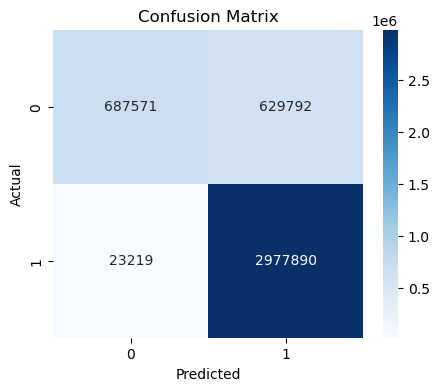

In [25]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# --- FIX ---
# Define a list with your actual class names
labels = [0, 1]

# Create the plot
plt.figure(figsize=(5, 4)) # Adjusted size for a 2x2 matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels) # Use the correct labels list

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
# Classification Report
print("\n=== Classification Report ===")


print(classification_report(y_true, y_pred, target_names=['0', '1']))



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.97      0.52      0.68   1317363
           1       0.83      0.99      0.90   3001109

    accuracy                           0.85   4318472
   macro avg       0.90      0.76      0.79   4318472
weighted avg       0.87      0.85      0.83   4318472



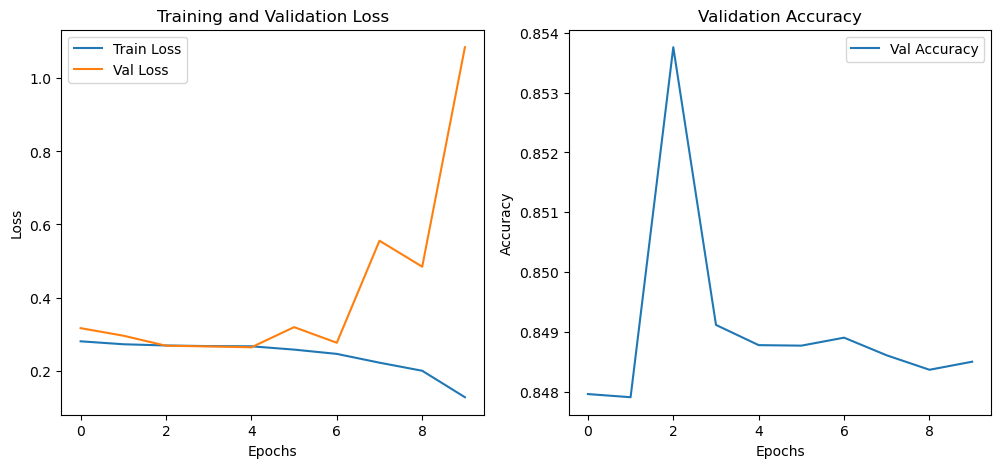

In [27]:
# Plot training history
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()